# Initial Setup

In [2]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

print(tf.__version__)

2.2.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [6]:
dataTrainDir = '/data/datasets/imagenet/raw/train'
dataValDir = '/data/datasets/imagenet/raw/validation'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'saved_models/imagenet_densenet_adamw_v2'
logsDir = 'logs/imagenet_densenet_adamw_v2'

In [7]:
BATCH_SIZE = 32
NUM_EPOCHS = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [12]:
if not os.path.exists(configDir):
    os.makedirs(configDir)

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
    os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
    os.makedirs(logsDir)

In [13]:
labelsFile = os.path.join(configDir, 'labels_imagenet.csv')

labelsName = next(os.walk(dataTrainDir))[1]
labelsName.sort()
print("Number of folders in TrainDir: {}".format(len(labelsName)))

labelsDF = pd.DataFrame()
labelsDF['name'] = labelsName
labelsDF['label'] = range(len(labelsName))

labelsDF.to_csv(labelsFile, index=False)

CLASS_NAMES = np.array(labelsName)

Number of folders in TrainDir: 1000


In [14]:
trainListDS = tf.data.Dataset.list_files(str(dataTrainDir+'/*/*'))
valListDS = tf.data.Dataset.list_files(str(dataValDir+'/*/*'))

tf.data.experimental.cardinality(trainListDS)

<tf.Tensor: shape=(), dtype=int64, numpy=1281167>

In [15]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


In [16]:
def rotate_zoom_tf(image, angle, zoom):

    angleRad = angle/180.*np.pi

    if image.shape.__len__() ==4:
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 1-zoom, maxval = 1+zoom)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (), minval = 1-zoom, maxval = 1+zoom)

    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, int(IMG_HEIGHT*random_zoom), int(IMG_WIDTH*random_zoom))
    img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)

    return img

def rotate_tf(image, angle):
    angleRad = angle/180.*np.pi
  
    if image.shape.__len__() ==4:
            
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
    
    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

    return img

def augment(image, label):
    #img = tf.image.rot90(image)
    img = tf.image.flip_left_right(image)
    #img = rotate_tf(image, 20)
    img = rotate_zoom_tf(image, 20, 0.2)
    #img = tf.image.random_brightness(img, 0.05)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return (img, label)
  
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

trainLabelDS = trainListDS.map(process_path, num_parallel_calls=AUTOTUNE)
valLabelDS = valListDS.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
'''
for image, label in trainLabelDS.take(1):
  
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
'''

'\nfor image, label in trainLabelDS.take(1):\n  \n  print("Image shape: ", image.numpy().shape)\n  print("Label: ", label.numpy())\n'

In [19]:
trainDS = prepare_for_training(trainLabelDS, cache="/data/tmp/imagenet.tfcache")
valDS = prepare_for_validation(valLabelDS)

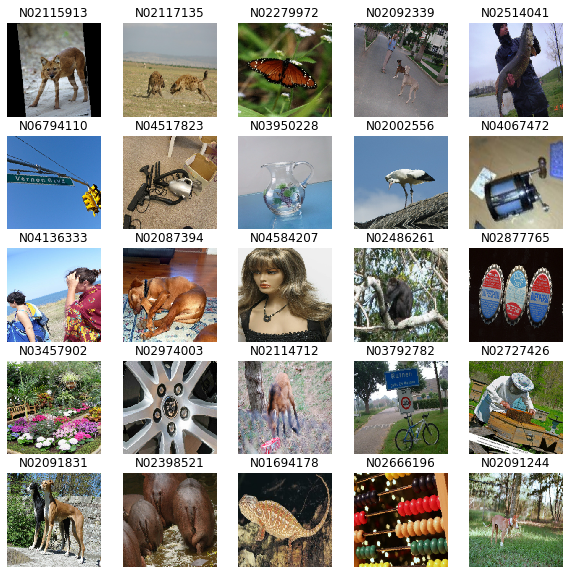

In [20]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

In [26]:
modelDiagramFile = os.path.join(resultsDir, 'model_densenet_imagenet_v2.png')

densenet121 = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), weights=None, include_top=False)
model = tf.keras.Sequential([densenet121, layers.GlobalAveragePooling2D(), layers.Dense(NUM_CLASSES, activation='softmax')])

#keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)
#model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1025000   
Total params: 8,062,504
Trainable params: 7,978,856
Non-trainable params: 83,648
_________________________________________________________________


In [38]:
paramMem = 14149480 * 4 / (1024**2) * 3
activationMem = 158400 * 2 * 4 / (1024**2)
miscMem = (IMG_HEIGHT*IMG_WIDTH*NUM_CHANNELS) * BATCH_SIZE * 4 / (1024**2) 

totalMem = ((activationMem * BATCH_SIZE) + paramMem + miscMem)/1024
totalMem

0.21384260058403015

## Train model

In [27]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 20, 30 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3

    if epoch >= 30:
        lr *= 1e-2
    elif epoch >= 20:
        lr *= 1e-1
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    print('Learning rate: ', lr)
    return lr


def wd_schedule(epoch):
    """Weight Decay Schedule
    Weight decay is scheduled to be reduced after 20, 30 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        wd (float32): weight decay
    """
    wd = 1e-4

    if epoch >= 30:
        wd *= 1e-2
    elif epoch >= 20:
        wd *= 1e-1
    
    print('Weight decay: ', wd)
    return wd


# just copy the implement of LearningRateScheduler, and then change the lr with weight_decay
@keras_export('keras.callbacks.WeightDecayScheduler')
class WeightDecayScheduler(keras.callbacks.Callback):
    """Weight Decay Scheduler.

    Arguments:
        schedule: a function that takes an epoch index as input
            (integer, indexed from 0) and returns a new
            weight decay as output (float).
        verbose: int. 0: quiet, 1: update messages.

    ```python
    # This function keeps the weight decay at 0.001 for the first ten epochs
    # and decreases it exponentially after that.
    def scheduler(epoch):
      if epoch < 10:
        return 0.001
      else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

    callback = WeightDecayScheduler(scheduler)
    model.fit(data, labels, epochs=100, callbacks=[callback],
              validation_data=(val_data, val_labels))
    ```
    """

    def __init__(self, schedule, verbose=0):
        super(WeightDecayScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'weight_decay'):
            raise ValueError('Optimizer must have a "weight_decay" attribute.')
        try:  # new API
            weight_decay = float(keras.backend.get_value(self.model.optimizer.weight_decay))
            weight_decay = self.schedule(epoch, weight_decay)
        except TypeError:  # Support for old API for backward compatibility
            weight_decay = self.schedule(epoch)
        if not isinstance(weight_decay, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        keras.backend.set_value(self.model.optimizer.weight_decay, weight_decay)
        if self.verbose > 0:
            print('\nEpoch %05d: WeightDecayScheduler reducing weight '
                  'decay to %s.' % (epoch + 1, weight_decay))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['weight_decay'] = keras.backend.get_value(self.model.optimizer.weight_decay)

In [28]:
optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule(0), weight_decay=wd_schedule(0), beta_1=0.9, beta_2=0.99)

Learning rate:  0.001
Weight decay:  0.0001


In [29]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logsCheckDir + "/metrics")
file_writer.set_as_default()

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)
#ck_callback = keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5"))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
wd_callback = WeightDecayScheduler(wd_schedule)

callbacks = [tb_callback, lr_callback, wd_callback]

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [30]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_data=valDS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Learning rate:  0.001
Weight decay:  0.0001
Epoch 1/50
  317/40037 [..............................] - ETA: 3:14:56 - loss: 7.0131 - accuracy: 0.0017

KeyboardInterrupt: 